In [1]:
import os
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import time
from new_benchmarks import *

In [2]:
#trialsDir = '/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/lu-data'
#trialsDir = '/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/ep-data'
#trialsDir = '/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/cg-data'
#trialsDir = '/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/sp-data'
#trialsDir = '/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/bt-data'
#trialsDir = '/g/g15/bolet1/workspace/benchmarks/rodinia/rodinia_3.1/openmp/cfd/cfd-data'
#trialsDir = '/g/g15/bolet1/workspace/faros/FAROS/bin/Quicksilver/omp/qs-data'
#trialsDir = '/g/g15/bolet1/workspace/faros/FAROS/bin/XSBench/omp/xsbench-data'
#trialsDir = '/g/g15/bolet1/workspace/faros/FAROS/bin/CoMD/omp/comd-data'
#trialsDir = '/g/g15/bolet1/workspace/benchmarks/rodinia/rodinia_3.1/openmp/heartwall/heartwall-data'
#trialsDir = '/g/g15/bolet1/workspace/lulesh-region-fix-correct/LULESH/build/lulesh-data/'

#trialsDir = '/g/g15/bolet1/workspace/faros/FAROS/bin/miniFE/omp/minife-data'
trialsDir = '/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/ft-data'

In [3]:
%%time
# let's open all the CSV files in the given directory
csvs = []
#for trial in trialsToUse:
csvs = csvs + list(glob.glob(trialsDir+'/../my-test/my-traces/trace-Optimal*.csv'))
    
print('Reading CSVs:\n', '\n'.join([os.path.basename(x) for x in csvs]))

df = pd.DataFrame()
for idx, csv in enumerate(csvs):
    print(csv, 'reading csv', idx+1, 'of', len(csvs), end='')
    starttime = time.time()
    rawdf = pd.read_csv(csv, sep=' ')
    df = df.append(rawdf)
    print(' -- Read in', time.time()-starttime, 'seconds')

Reading CSVs:
 trace-Optimal-region-ft.c.apollo.region.l199-rank-0.csv
trace-Optimal-region-ft.c.apollo.region.l376-rank-0.csv
trace-Optimal-region-ft.c.apollo.region.l263-rank-0.csv
trace-Optimal-region-ft.c.apollo.region.l447-rank-0.csv
trace-Optimal-region-ft.c.apollo.region.l480-rank-0.csv
trace-Optimal-region-ft.c.apollo.region.l513-rank-0.csv
trace-Optimal-region-ft.c.apollo.region.l223-rank-0.csv
trace-Optimal-region-ft.c.apollo.region.l676-rank-0.csv
/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/ft-data/../my-test/my-traces/trace-Optimal-region-ft.c.apollo.region.l199-rank-0.csv reading csv 1 of 8 -- Read in 0.014672994613647461 seconds
/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/ft-data/../my-test/my-traces/trace-Optimal-region-ft.c.apollo.region.l376-rank-0.csv reading csv 2 of 8 -- Read in 0.007382631301879883 seconds
/g/g15/bolet1/workspace/benchmarks/NPB/SNU_NPB_2019/NPB3.3-OMP-C/bin/ft-data/../my-test/my-traces/trace-Optimal

In [4]:
%%time

# let's only keep a few columns
df = df[['region', 'globalidx', 'policy', 'xtime']]
df = df.reset_index(drop=True)

# average out the xtimes for each trial
#if len(trialsToUse) > 1:
df = df.groupby(['region', 'globalidx', 'policy'])['xtime'].mean().reset_index().sort_values(by=['globalidx'])   

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 13.5 ms


In [5]:
%%time
# sanity check the shape
print(df.shape)
print(df.columns)

# if we're working with lulesh data, let's plot the beginning data
#luleshdf = df.loc[(df['globalidx'] <= 15000) & (df['globalidx'] >= 10000)]

(111, 4)
Index(['region', 'globalidx', 'policy', 'xtime'], dtype='object')
CPU times: user 462 µs, sys: 104 µs, total: 566 µs
Wall time: 509 µs


In [6]:
def plotTraces(df, skipPlot=False):
    #df = df.loc[[ (x in policiesToPlot) for x in df['policy']]]
    df = df.copy()
    
    grouped = df.groupby(['region', 'globalidx'])
    mins = df.loc[grouped['xtime'].idxmin()]
    toplot = mins.sort_values(by=['globalidx']).reset_index(drop=True)
    #toplot = mins.copy()
    
    # We will also count the number of unique regions, discrtize, and map them to integers
    regions = list(toplot['region'].unique())
    num_regions = len(regions)

    region_map = dict(zip(regions, range(num_regions)))

    # set the starting point of all the groups of policies
    toplot['x_end'] = toplot['xtime'].cumsum()
    toplot['x_start'] = toplot['x_end'].shift(fill_value=0)

    #toplot.drop('policy', axis=1, inplace=True)
    toplot.drop('xtime', axis=1, inplace=True)
    
    # make the y-axis values for each datapoint
    toplot['y'] = toplot.apply(lambda row: region_map[row.region], axis=1)
    
    policyColors = ['red', 'green', 'blue', 'cyan', 'magenta', 'black', 'orange', 'yellow']
    
    print('optimal xtime is:', toplot['x_end'].max(), 'seconds')
    
    if skipPlot:
        return
    
    # Now that we have the necessary columns, let's plot ALL the policies
    fig1, ax1 = plt.subplots()
    fig1.set_size_inches(18, 10)
    fig1.set_dpi(500)
    
    numThreads = [36,34,30,26,22,18,16,12,8,4,1,72]
    proc_binds = ['close', 'spread']
    
    cm = plt.get_cmap('hsv')
    NUM_COLORS = len(numThreads)*len(proc_binds)//2
    policyColors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    
    policyNames = [str((str(i),j)) for i in numThreads for j in proc_binds]
    print(policyNames)
    #ax1.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    for index, row in toplot.iterrows():
        marker = 'o' if 'close' in policyNames[row.policy] else 'x'
        color = policyColors[row.policy//2]
        ax1.plot([row.x_start, row.x_end], [row.y, row.y], color=color,   label=str(policyNames[row.policy]), marker=marker, markersize=4)
        #ax1.plot([row.x_start, row.x_end], [row.y, row.y], color=policyColors[row.policy],   label='policy'+str(row.policy), marker='o', markersize=4)
        if (index % 1000) == 0:
            print('current index: ', index, '(', 100*(index+1)/toplot.shape[0] ,')')


    ax1.set_title(trialsDir+' Execution Under "Optimal" Oracle Policy')
    #ax1.set_yticklabels(regions)
    ax1.set_yticks(list(region_map.values()))
    ax1.set_yticklabels(list(region_map.keys()))
    ax1.set_xlabel('Execution Time (seconds)')

    # reorder the labels
    handles, labels = plt.gca().get_legend_handles_labels()
    new_handles = []
    new_labels = []
    for pName in policyNames:
        for idx, label in enumerate(labels):
            if pName == label:
                new_handles.append(handles[idx])
                new_labels.append(label)
    #print('new labels')
    #print(new_handles)
    #print(new_labels)
    by_label = dict(zip(new_labels, new_handles))
    plt.legend(by_label.values(), by_label.keys(), ncol=3, loc='best')#, bbox_to_anchor=(0.5, -0.15))
    plt.show()
    
    

    return
    

optimal xtime is: 19.377105530899993 seconds
["('36', 'close')", "('36', 'spread')", "('34', 'close')", "('34', 'spread')", "('30', 'close')", "('30', 'spread')", "('26', 'close')", "('26', 'spread')", "('22', 'close')", "('22', 'spread')", "('18', 'close')", "('18', 'spread')", "('16', 'close')", "('16', 'spread')", "('12', 'close')", "('12', 'spread')", "('8', 'close')", "('8', 'spread')", "('4', 'close')", "('4', 'spread')", "('1', 'close')", "('1', 'spread')", "('72', 'close')", "('72', 'spread')"]
current index:  0 ( 0.9009009009009009 )


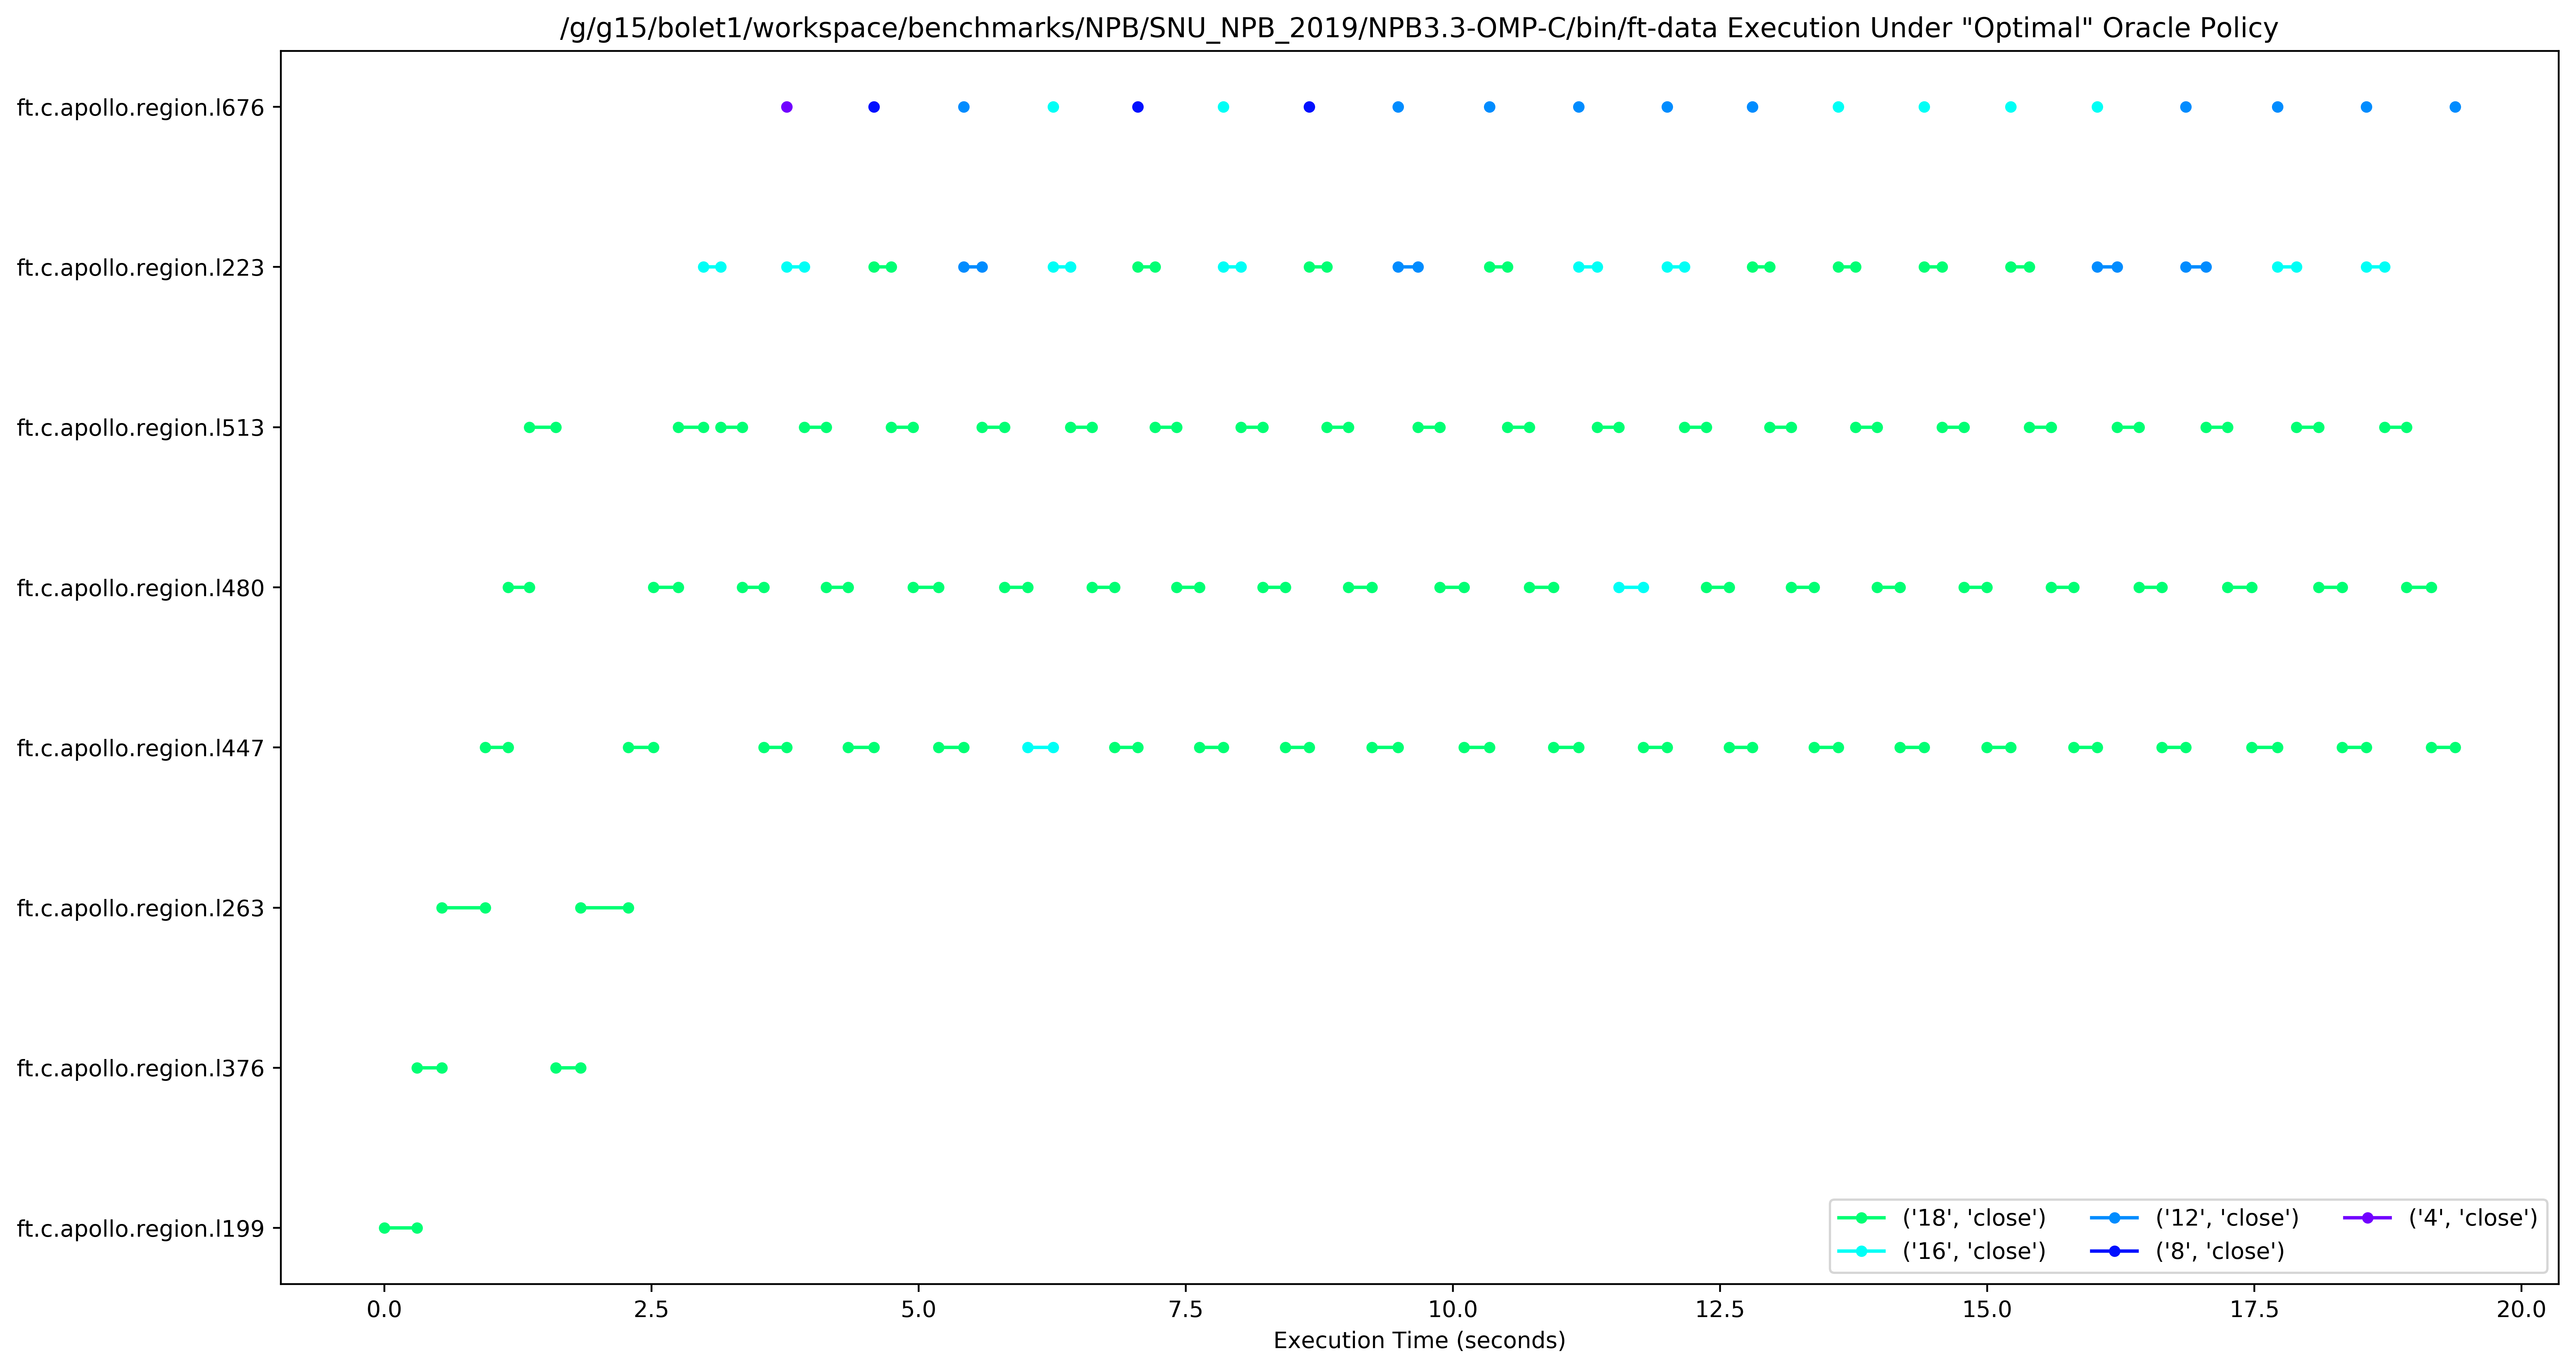

CPU times: user 5.41 s, sys: 97.2 ms, total: 5.51 s
Wall time: 5.48 s


In [7]:
%%time
plotTraces(df)


In [8]:
# check out a particular region and find the indices of the biggest runs
tR = df[df['region'] == 'ft.c.apollo.region.l223']
tR = tR.sort_values(by=['xtime'], ascending=False).reset_index(drop=True)
print(tR.head())

                    region  globalidx  policy     xtime
0  ft.c.apollo.region.l223         91      14  0.188052
1  ft.c.apollo.region.l223         96      14  0.187193
2  ft.c.apollo.region.l223         51      14  0.184746
3  ft.c.apollo.region.l223        101      12  0.178067
4  ft.c.apollo.region.l223         61      12  0.173480


In [9]:
# let's check out what regions execute before and after globalidx=684 #targetIdx = r517.iloc[0]['globalidx']
targetIdx = tR.iloc[0]['globalidx']
bound=15
print(df[(df['globalidx'] > targetIdx-bound) & (df['globalidx'] < targetIdx+bound) ])

                      region  globalidx  policy     xtime
84   ft.c.apollo.region.l513         77      10  0.202874
62   ft.c.apollo.region.l480         78      10  0.214102
40   ft.c.apollo.region.l447         79      10  0.224684
104  ft.c.apollo.region.l676         80      12  0.000018
15   ft.c.apollo.region.l223         81      10  0.170793
85   ft.c.apollo.region.l513         82      10  0.203239
63   ft.c.apollo.region.l480         83      10  0.213974
41   ft.c.apollo.region.l447         84      10  0.224611
105  ft.c.apollo.region.l676         85      12  0.000019
16   ft.c.apollo.region.l223         86      10  0.171699
86   ft.c.apollo.region.l513         87      10  0.204400
64   ft.c.apollo.region.l480         88      10  0.213783
42   ft.c.apollo.region.l447         89      10  0.217862
106  ft.c.apollo.region.l676         90      12  0.000018
17   ft.c.apollo.region.l223         91      14  0.188052
87   ft.c.apollo.region.l513         92      10  0.204559
65   ft.c.apol